# Agricultural Satellite Image Segmentation
> Classifying each pixel of an agricultural satellite image

- toc: true
- badges: true
- comments: true
- categories: [ComputerVision, ImageSegmentation]
- image: 

In [ ]:
!gdown --id 1f31SgXXXXXXXXXXXX #60-band-image
!gdown --id 19EG9fXXXXXXXXXXXX #annotation 

### Libraries

In [ ]:
import os
import csv
import random
import datetime
import numpy as np
from pathlib import Path
from pandas import DataFrame
from tqdm.notebook import tqdm

from PIL import Image
import seaborn as sns
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import backend as K

### Parameters

In [ ]:
filelist_trainx = ['data_60bands.npy']
filelist_trainy = ['labels.npy']

label_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 6:5, 7:6, 8:7}

label_dict_x = {0:'Background', 
              1:'Crop 1', 
              2:'Crop 2', 
              3:'Crop 3', 
              4:'Crop 4', 
              5:'Crop 5', 
              6:'Crop 6', 
              7:'Crop 7'}

color_dict = {0: [0, 0, 0], 
              1: [255,215,0], 
              2: [0,128,0], 
              3: [0,0,128],
              4: [128,0,128], 
              5: [0,128,128], 
              6: [128,0,0], 
              7: [128,128,128]}

weight_dict = {0: 0, 1: 12, 2: 10, 3: 15, 4: 24, 5: 28, 6: 30, 7: 10}
# weight_dict = {0: 1.0, 1: 124.71, 2: 97.24, 3: 154.72, 4: 244.87, 5: 286.02, 6: 296.12, 7: 100.67}
CLASS_WEIGHTS = list(weight_dict.values())


TEST_RATIO = 0.2
THRESHOLD = .95
N_BANDS = 60
N_CLASSES = 8
N_FILTERS = 32
N_EPOCHS = 50
PATCH_SZ = 128
BATCH_SIZE = 16
smooth = 1e-12

### Utils

In [ ]:
def train_test_split(data, test_ratio=0.2):
  train_size = int((1 - test_ratio) * data.shape[1])
  if len(data.shape)==3:
    train = data[:, :train_size, :]
    test = data[:, train_size:, :]
  else:
    train = data[:, :train_size]
    test = data[:, train_size:]
  return train, test

def maskohe(mask):
  return to_categorical(mask, num_classes=N_CLASSES)

def maskrgb(mask, ohe=False):
  if ohe:
    mask = np.argmax(mask, axis=-1)
  color = np.array(list(color_dict.values()))
  mask = color[mask.ravel()].reshape(mask.shape+(3,)).astype('uint8')
  mask = mask/255
  return mask

def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[0,:,:].numpy()
  pred_mask = maskrgb(pred_mask)
  return pred_mask

def vis_segmentation(image, seg_map, figsize=4):
    """Converts one-hot mask into 2d-label array"""
    seg_map = np.argmax(seg_map, axis=-1) if seg_map.ndim==3 else seg_map

    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(figsize*3, figsize))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = maskrgb(seg_map)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.2)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(maskrgb(unique_labels.reshape(-1,1)), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), [label_dict_x[x] for x in unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

In [ ]:
data_raw = np.load(filelist_trainx[0])
mask_raw = np.load(filelist_trainy[0])

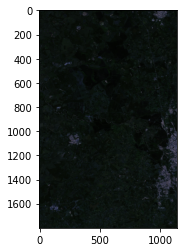

In [ ]:
# data handle
data = np.moveaxis(data_raw, 0, -1)

scalers = {}
for i in range(data.shape[-1]):
    scalers[i] = StandardScaler()
    data[:, :, i] = scalers[i].fit_transform(data[:,:,i].ravel().reshape(-1,1)).reshape(data.shape[0], data.shape[1])
    
scalers = {}
for i in range(data.shape[-1]):
    scalers[i] = MinMaxScaler()
    data[:, :, i] = scalers[i].fit_transform(data[:,:,i].ravel().reshape(-1,1)).reshape(data.shape[0], data.shape[1])

plt.imshow(data[:,:,:3]); plt.show()

  Background    Crop 1    Crop 2    Crop 3    Crop 4    Crop 5    Crop 6    Crop 7
------------  --------  --------  --------  --------  --------  --------  --------
  1.9538e+06     15667     20093     12628      7979      6831      6598     19407


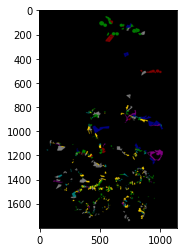

In [ ]:
# mask handle
mask = np.vectorize(label_dict.get)(mask_raw)

unique, counts = np.unique(mask, return_counts=True)
print(tabulate([counts], headers=[label_dict_x[x] for x in unique]))

mask_rgb = maskrgb(mask)
mask_ohe = maskohe(mask)

plt.imshow(mask_rgb); plt.show()

### Visualize

In [ ]:
H_MARK = 1400
W_MARK = 600
SIZE = 200
SEASON = 4

x = H_MARK; y = W_MARK; z = SIZE; s = (SEASON-1)*5
vis_segmentation(data[x:x+z,y:y+z,s:s+3], mask[x:x+z,y:y+z], 5)

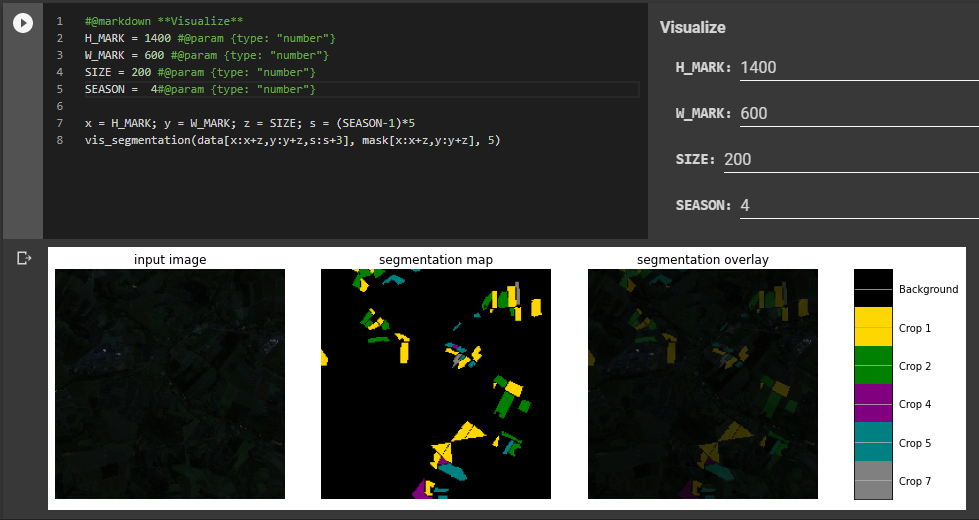

### Generate samples

In [ ]:
N_PATCHES = 3000
PATCH_SZ =  128
THRESHOLD = 95

def get_rand_patch(img, mask, sz=160):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]

    # Apply some random transformations
    random_transformation = np.random.randint(1,8)
    if random_transformation == 1:  # reverse first dimension
        patch_img = patch_img[::-1,:,:]
        patch_mask = patch_mask[::-1,:,:]
    elif random_transformation == 2:    # reverse second dimension
        patch_img = patch_img[:,::-1,:]
        patch_mask = patch_mask[:,::-1,:]
    elif random_transformation == 3:    # transpose(interchange) first and second dimensions
        patch_img = patch_img.transpose([1,0,2])
        patch_mask = patch_mask.transpose([1,0,2])
    elif random_transformation == 4:
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif random_transformation == 5:
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif random_transformation == 6:
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        pass

    return patch_img, patch_mask


def get_patches(img, mask, n_patches, path='.', sz=160):

    img_path = Path(os.path.join(path,'images'))
    img_path.mkdir(parents=True, exist_ok=True)
    mask_path = Path(os.path.join(path,'masks'))
    mask_path.mkdir(parents=True, exist_ok=True)

    idx = 0
    pbar = tqdm(total=n_patches)
    while idx < n_patches:
      img_patch, mask_patch = get_rand_patch(img, maskohe(mask), sz)
      _ , count = np.unique(np.argmax(mask_patch, axis=-1), return_counts=True)
      if(max(count) < (sz*sz*THRESHOLD/100)):
        np.save(img_path / f"image_{idx}.npy", np.array(img_patch))
        np.save(mask_path / f"mask_{idx}.npy", np.array(mask_patch))
        idx += 1
        pbar.update(1)
    pbar.close()

get_patches(data, mask, N_PATCHES, '/content/data/', PATCH_SZ)

In [2]:
# Image_id =  50
# Image_size = 7

# sample_image = np.load(f'/content/data/images/image_{Image_id}.npy')
# sample_mask = np.load(f'/content/data/masks/mask_{Image_id}.npy')
# vis_segmentation(sample_image[:,:,:3], sample_mask, Image_size)

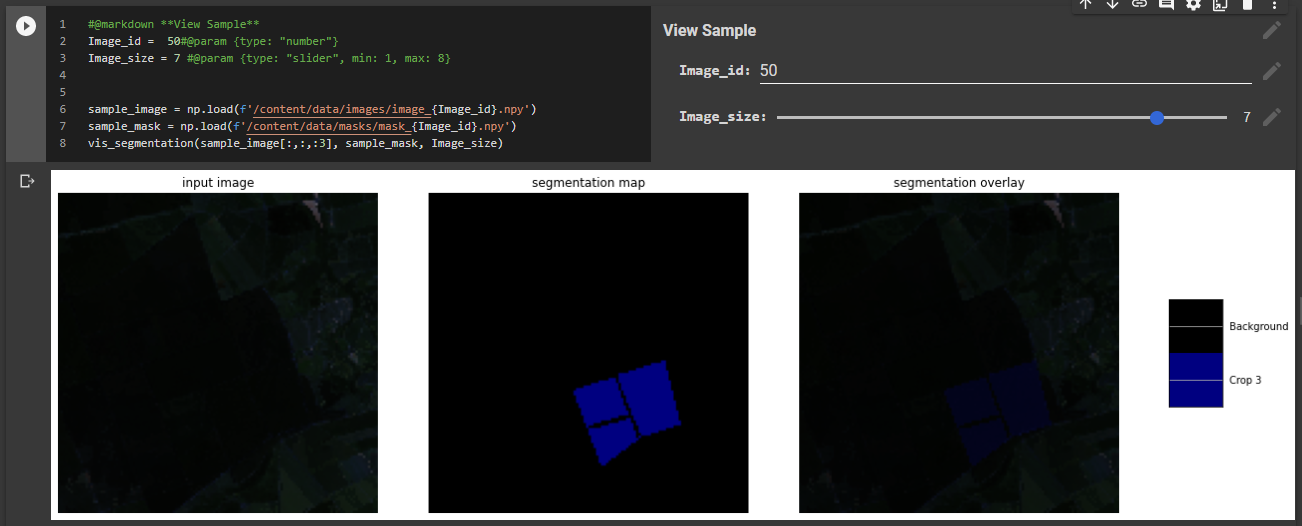

### Data loader

(16, 128, 128, 60) (16, 128, 128, 8)


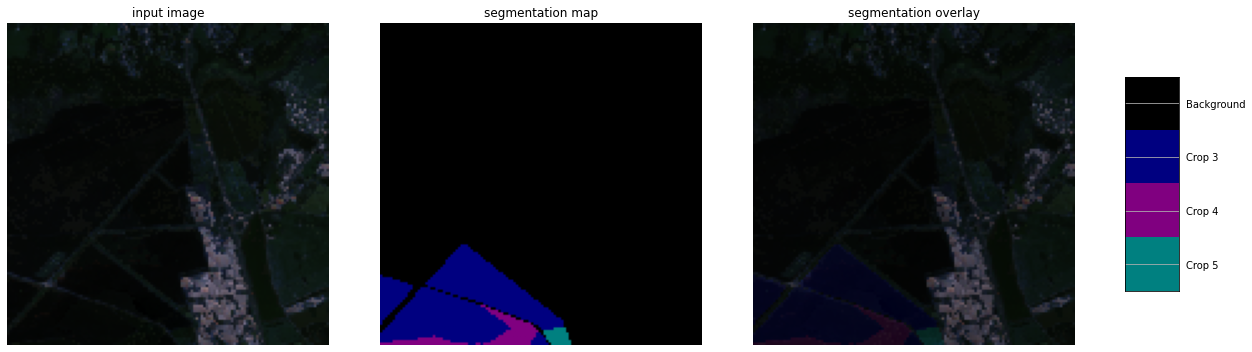

In [ ]:
class AgriCrops(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, img_channels, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_channels = img_channels
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (self.img_channels,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = np.load(path)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (8,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = np.load(path)
            y[j] = img
        return x, y


# Data paths
input_dir = '/content/data/images'
target_dir = '/content/data/masks'
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)])

# Shuffling
val_samples = 500
SEED = 40
random.Random(SEED).shuffle(input_img_paths)
random.Random(SEED).shuffle(target_img_paths)

# Split our img paths into a training and a validation set
train_input_img_dir = input_img_paths[:-val_samples]
train_target_img_dir = target_img_paths[:-val_samples]
test_input_img_dir = input_img_paths[-val_samples:]
test_target_img_dir = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = AgriCrops(BATCH_SIZE, (PATCH_SZ,PATCH_SZ), N_BANDS, 
                      train_input_img_dir, train_target_img_dir)

val_gen = AgriCrops(BATCH_SIZE, (PATCH_SZ,PATCH_SZ), N_BANDS, 
                    test_input_img_dir, test_target_img_dir)

x, y = val_gen.__getitem__(np.random.randint(0,10))
print(x.shape, y.shape)

image_id = np.random.randint(0,BATCH_SIZE)
sample_image, sample_mask = x[image_id,:,:,:], y[image_id,:,:,:]
# display([sample_image[:,:,:3], maskrgb(sample_mask, ohe=True)])
vis_segmentation(sample_image[:,:,:3], sample_mask, 7)

In [ ]:
def show_predictions(dataset=train_gen, num=1):
  x, y = dataset.__getitem__(0)
  for i in range(num):
    display([x[i,:,:,:3], maskrgb(y[i,...], ohe=True), create_mask(model.predict(x[i:i+1, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(train_gen, num=3)
    show_predictions(val_gen, num=2)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Model architecture

In [ ]:
def model1(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))

    def jack_coef(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[0, 1, 2])
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[0, 1, 2])
        jack = (intersection + smooth)/(sum_ - intersection + smooth)
        return K.sum(jack * class_weights, axis=-1, keepdims=False)

    def dice_loss(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[0, 1, 2])
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[0, 1, 2])
        dice = (2. * intersection + smooth) / (sum_ + smooth)
        return 1 - K.sum(dice * class_weights, axis=-1, keepdims=False)

    def overall_loss(y_true, y_pred):
        return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy, metrics=[jack_coef])
    return model

In [ ]:
class_weights = list(weight_dict.values())
class_weights = [float(i)/sum(class_weights) for i in class_weights]
class_weights

[0.0,
 0.09302325581395349,
 0.07751937984496124,
 0.11627906976744186,
 0.18604651162790697,
 0.21705426356589147,
 0.23255813953488372,
 0.07751937984496124]

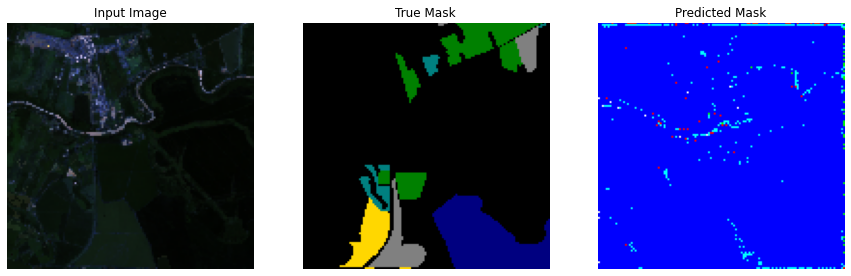

In [ ]:
keras.backend.clear_session()
model = model1(N_CLASSES, PATCH_SZ, N_BANDS, N_FILTERS, class_weights=class_weights)
model = model1((PATCH_SZ, PATCH_SZ, N_BANDS), N_CLASSES)
show_predictions(val_gen, num=1)

In [ ]:
model.load_weights('/content/AgriSeg/archived/agricrop_segmentation.h5')

### Model training

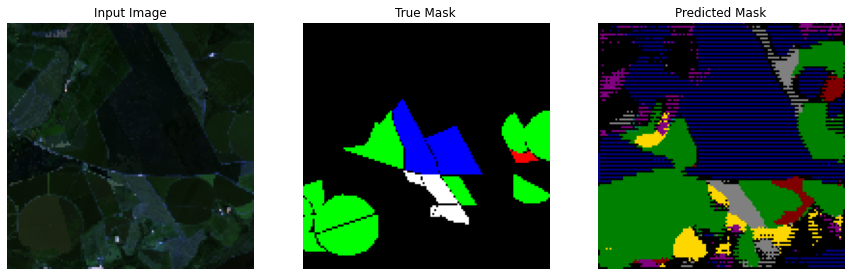

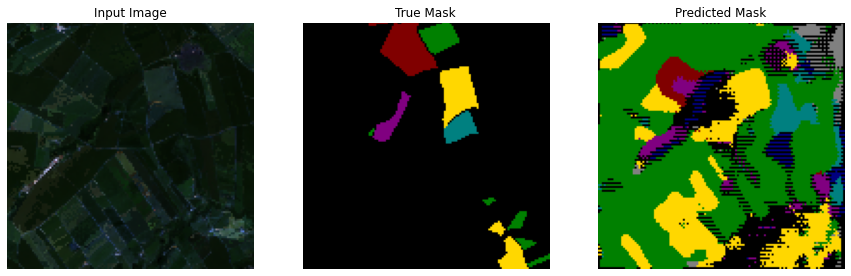

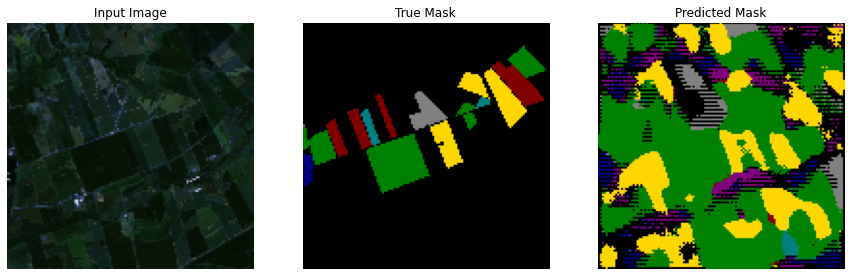

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("agricrop_segmentation.h5", save_best_only=True), 
             tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.05, patience=3, min_lr=0.000001, verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True),
             tf.keras.callbacks.CSVLogger('log_unet.csv', append=True, separator=';'),
             DisplayCallback()]

history = model.fit(train_gen, 
                    epochs=N_EPOCHS, 
                    validation_data=val_gen, 
                    callbacks=callbacks,
                    shuffle=True,
                    # steps_per_epoch=20, 
                    # validation_steps=5
                    )

In [ ]:
!cp agricrop_segmentation.h5 '/content/AgriSeg/archived/agricrop_segmentation_unnormalized_classsweights.h5'

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(50)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Model results

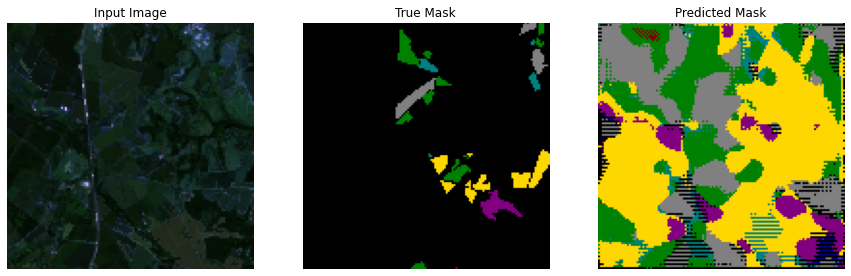

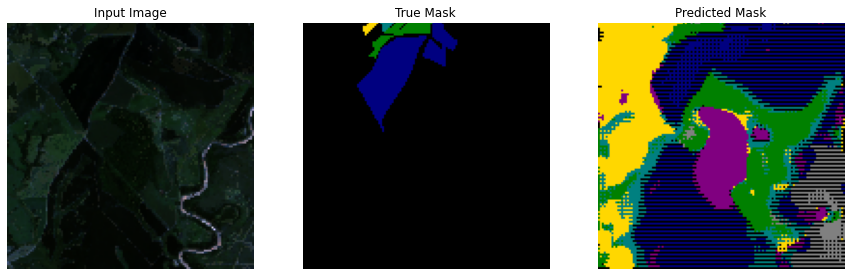

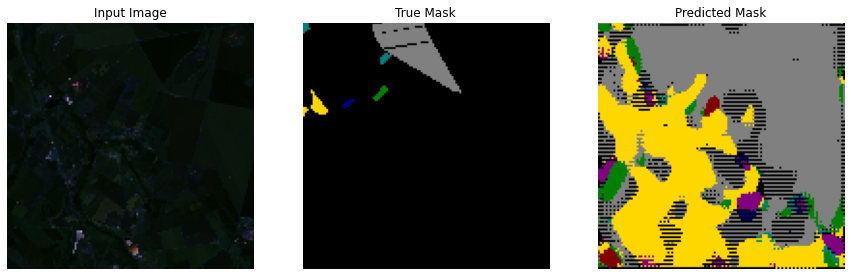

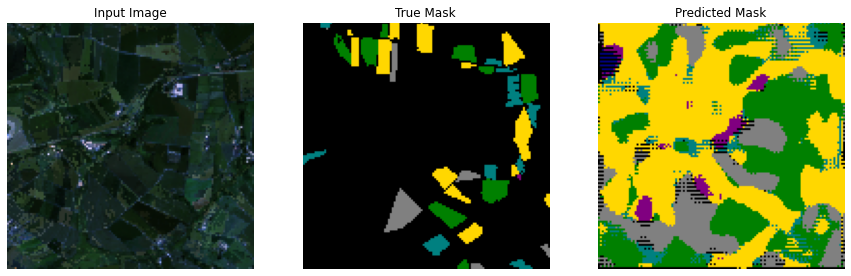

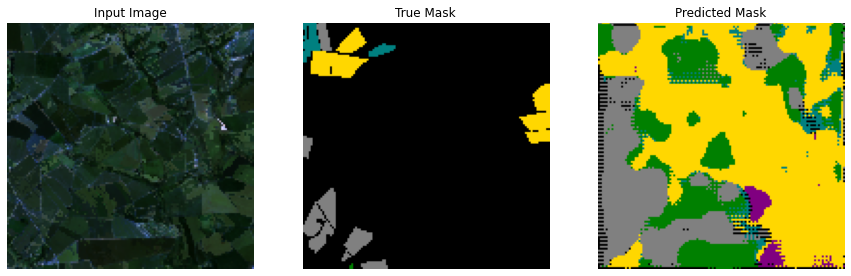

In [ ]:
show_predictions(val_gen, 5)